## Let's create a reservoir network with two readout neurons:

In [1]:
"""
TODO:
refractoriness DONE
inhibitory connections between readout neurons DONE
synaptic delay - DONE, but play with it
STDP
tau presynaptic/ tau postsynaptic
"""


'\nTODO:\nrefractoriness DONE\ninhibitory connections between readout neurons DONE\nsynaptic delay - DONE, but play with it\nSTDP\ntau presynaptic/ tau postsynaptic\n'

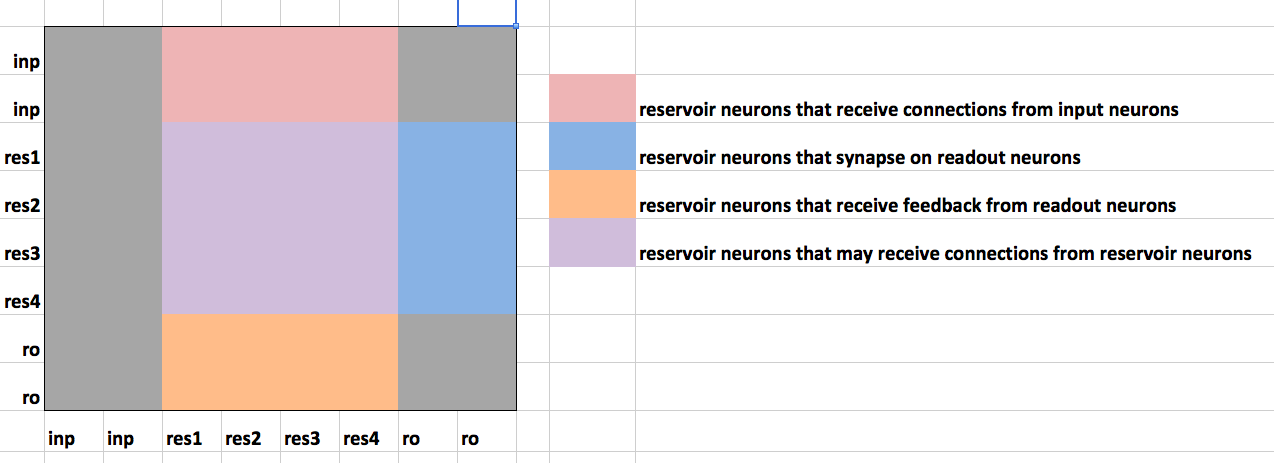

In [3]:
import numpy as np
from utils import axvlines as pltX
import matplotlib.pyplot as plt
from NeuroTools import stgen
from utils import axvlines as pltX
from NeuroTools import stgen
from scipy.signal import find_peaks
import time as TIME
from scipy.stats import binom
from sklearn import preprocessing

In [2]:
"""
            UTILITY FUNCTIONS:
"""

np.random.seed(10)

def plot_stimulus(tt,mm):
    plt.figure(figsize=(15,2))
    plt.plot(tt, mm)
    plt.tight_layout()
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('Stimulus, k:')

def plot_spikes(net, T, dt, V, neur_ids=[1,2,3]):
    plt.figure(figsize=(15,2 + len(neur_ids)))
    c = 0
    time = np.arange(0,T, dt)
    for i in neur_ids:
        c += 1
        plt.subplot(len(neur_ids), 1, c)
        plt.plot(time, V[:,i])
        plt.tight_layout()
        ax = plt.gca()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        cur_type = net.neurons[i].neur_type
        listens_to = net.neurons[i].listens_to
        tit ='{} neuron #: {}. Listens to: {}'.format(
            'EXC' if cur_type==0 else (
                'INH' if cur_type==1 else(
                    'INP' if cur_type==2 else 'RO')),
            i, listens_to)
        plt.title(tit)
        
def plot_conductances(neur_id, net, T, dt):
    time = np.arange(0,T,dt)
    plt.figure(figsize=(15,5))
    plt.subplot(3,1,1)
    for i in range(net.M):
        plt.plot(time, gAMPA[neur_id,i,:])
        plt.title('AMPA in Neuron: {}'.format(neur_id))
        plt.legend(range(net.M), title='Syn')
        ax = plt.gca()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.subplot(3,1,2)
    for i in range(net.M):
        plt.plot(time, gNMDA[neur_id,i,:])
        plt.title('NMDA in Neuron: {}'.format(neur_id))
        plt.legend(range(net.M), title='Syn')
        ax = plt.gca()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.subplot(3,1,3)
    for i in range(net.M):
        plt.plot(time, gGABA[neur_id,i,:])
        plt.title('GABA in Neuron: {}'.format(neur_id))
        plt.legend(range(net.M), title='Syn')
        ax = plt.gca()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.tight_layout()

def plot_raster(V):
    spike_mat = V.T
    spike_mat_conv = np.zeros_like(spike_mat)
    for i in range(spike_mat.shape[0]):
        peaks, properties = find_peaks(spike_mat[i,:], prominence=10)
        train = np.zeros_like(spike_mat[i,:])
        train[peaks] = 1
        spike_mat_conv[i, :] = np.convolve(train, np.ones((5,))/5, mode='same')

    plt.figure(figsize = (17,5))
    plt.imshow(spike_mat_conv, interpolation='none', aspect='auto', cmap='Greys')
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])
    
def get_stimulus(T):
    f = 5
    tt = np.linspace(0, T, 15)
    mm = 5 * (np.sin(2*np.pi*f/1000*tt) + 1)
    mm[8:] = 8
    return tt, mm

def simulate(net, stim, T, dt):
    start_time = TIME.time()
    V, i, c = [], 0, 0
    time = np.arange(0, T, dt)
    gAMPA = np.zeros((net.M, net.M, len(time)))
    gNMDA = np.zeros((net.M, net.M, len(time)))
    gGABA = np.zeros((net.M, net.M, len(time)))
    postsyn_act = np.zeros((net.M, net.M, len(time)))
    presyn_act = np.zeros((net.M, net.M, len(time)))
    eligibility = np.zeros((net.M, net.M, len(time)))
    k = stim[c]
    for t in time:
        if t>tt[c]:
            c += 1
            k = stim[c]
        v = net.step(dt, k)
        for n in range(net.N_in, len(net.neurons)):
            for syn in range(net.M):
                gAMPA[n,syn,i] = net.neurons[n].synapses[syn].g_AMPA
                gNMDA[n,syn,i] = net.neurons[n].synapses[syn].g_NMDA
                gGABA[n,syn,i] = net.neurons[n].synapses[syn].g_GABA
#                 if net.neurons[n].synapses[syn].postsyn_act > 0:
#                     print(n, syn, i)
                postsyn_act[n,syn,i] = net.neurons[n].synapses[syn].postsyn_act
                presyn_act[n,syn,i] = net.neurons[n].synapses[syn].presyn_act
                eligibility[n,syn,i] = net.neurons[n].synapses[syn].eligibility
        V.append(v)
        i+=1
    V = np.vstack(V)
    print('Simulation time: {} seconds'.format(TIME.time() - start_time))
    return V, gAMPA, gNMDA, gGABA, postsyn_act, presyn_act, eligibility

def plot_tuning_curves(net):
    plt.figure(figsize=(15,5))
    K = np.linspace(0,10,100)
    for i in range(net.N_in):
        R = []
        for k in K:
            V = net.step(0.05, k)
            R.append(net.neurons[i].r)
        plt.plot(K,R)
    net = Network()
    plt.legend(np.arange(len(net.neurons)).tolist())
    plt.title('Tuning curves of input neurons')
    plt.ylabel('Firing rate')
    plt.xlabel('Stimulus value')

In [3]:
class Neuron_():
    def __init__(self, V0=-65, Ie=0, num_synapses=[], neur_type=[], i=[], k=[], N_in=[], idx_in_network=[]):
        self.neur_type = neur_type # excitatory or inhibitory
        self.idx_in_network = idx_in_network
        if self.neur_type==2:
            self.i = i        # index of input neuron
            self.k = k        # preceding stimulus type
            self.N_in = N_in  # number in input neurons
            self.r = 0
            self.old_k = -333333
            self.spike_train = []
            self.spike_counter = 0
            self.timer = 0
            self.listens_to = None
        else:          
            self.V_E = 0      # equilibrium potential for the excitatory synapse
            self.V_I = -80    # equilibrium potential for the inhibitory synapse
            self.I_I = 0
            self.I_E = 0
            
            # initialize the axon's signalaling (what neurotransmitter this neuron can release):
            self.num_synapses = num_synapses
            self.synapses = []
            for i in range(self.num_synapses):
                self.synapses.append(self.Synapse(belongs_to=self.idx_in_network, index=i))

        # neuron's electric constants:
        self.Ie = Ie if self.neur_type != 2 else None       # external current, nA
        self.tau = 10 if neur_type==0 or neur_type==2 else 20 # ms
        self.Vth = -55    # threshold after which an AP is fired,   mV
        self.Vr = -70     # reset voltage (after an AP is fired), mV
        self.EL = -65     # leakage potential, mV
        self.Vspike = 0
        self.AP = 0

        self.refractory_period = 1 # ms
        self.time_since_last_spike = 1

        # Intial conditions
        self.V = V0 # intial membrane voltage
     

    def update_r(self, k):
        N_in = self.N_in
        R_max = 110
        sigma = 0.25 ################  0.15
        L = 0.4
        i = self.i
        self.r = (R_max/L)*np.exp(-(i/N_in - 0.1*(k))**2/(2*(sigma*L)**2))
#         print('RUN FUNCTION UPDATE_R, i: {}'.format(self.i))
    
    def get_spike_train(self):
        st_gen = stgen.StGen()
        T = 100000
        rate = np.array([0.8, 0.9, 1, 1.1, 1.2]) * self.r
        rate = np.array([max(rate[i], 0.1) for i in range(len(rate))]) # we don't want frequencies lower than 0.1 Hz
        time = np.linspace(0,T,6)
        time = time[:-1]
        a = st_gen.inh_poisson_generator(rate=rate, t=time, t_stop=T, array=True)
        self.spike_train = a.T
#         print('RUN FUNCTION get_spike_train, i: {}'.format(self.i))
#         print('spike_train:\n, {}\n'.format(self.spike_train))


    def check4spike(self, dt, k):
        self.timer += dt
        if self.timer > self.spike_train[self.spike_counter]:
            self.AP = 1
            self.spike_counter += 1
        try:
            tmp = self.spike_train[self.spike_counter + 2]
        except IndexError:
            print('Generating new spikes')
            self.timer = 0
            self.spike_counter = 0
            self.spike_train = []
            self.update_r(k)
            self.get_spike_train()


    def step(self, dt, k=0):
        """
        MAKE ONE TIME STEP TO UPDATE THE NEURON'S PARAMETERS
        """
        if self.neur_type != 2:
            for synapse in self.synapses:
                synapse.update(dt)
            
            # IAF model: dV/dt is membrane current.
            g_AMPA = np.sum([self.synapses[i].g_AMPA for i in range(self.num_synapses)])
            g_NMDA = np.sum([self.synapses[i].g_NMDA for i in range(self.num_synapses)])
            self.I_E = -g_AMPA*(self.V - self.V_E) - 0.1*g_NMDA*(self.V - self.V_E)
            g_GABA = np.sum([self.synapses[i].g_GABA for i in range(self.num_synapses)])
            self.I_I = -g_GABA*(self.V - self.V_I)
            dV = (-(self.V - self.EL)/self.tau + self.I_E + self.I_I + self.Ie)*dt
            
            self.time_since_last_spike += dt
        
            if self.AP==1:
                self.AP = 0
                self.V = self.Vr

            # if the threshold voltage is reached, fire and action potential:
            if self.V > self.Vth and self.AP==0 and self.time_since_last_spike >= self.refractory_period:
                self.V = self.Vspike
                self.AP = 1
                self.time_since_last_spike = 0
                for synapse in self.synapses:
                    synapse.postsynaptic_AP = 1

            if self.AP==0:
                self.V += dV
        
        if self.neur_type == 2:
            if k != self.old_k:
                self.timer = 0
                self.spike_counter = 0
                self.spike_train = []
                self.update_r(k)
                self.get_spike_train()
                self.old_k = k
            self.check4spike(dt, k)
            if self.AP==1 and self.V != self.Vspike:
                self.V = self.Vspike
            elif self.AP==1 and self.V==self.Vspike:
                self.V = self.EL
                self.AP = 0
            else:
                pass
            

        return self.V
    
    class Synapse:
        def __init__(self, belongs_to=[], index=[], listens_to=[]):
            self.neur_type = [] # The type of neuron this synapse LISTENS_TO, not the type of neuron it BELONGS_TO
            self.incoming_AP = 0 # action potential on the neuron this synapse listens to
            self.postsynaptic_AP = 0
            # synaptic conductances:
            self.g_GABA = 0
            self.g_AMPA = 0
            self.g_NMDA = 0
            # tau-parameters
            self.tau_AMPA = 8
            self.tau_NMDA = 100
            self.tau_GABA = 8
            self.W = 0        # weight
            self.listens_to = listens_to
            self.belongs_to = belongs_to
            self.index = index
            self.tau_postsyn = 100
            self.tau_presyn = 10
            self.presyn_act = 0
            self.postsyn_act = 0
            self.tau_e = 20
            self.el_lr = 0.01
            self.eligibility = 0
            
        def update(self, dt):
            n_type = net.neurons[self.belongs_to].neur_type # get the type of neuron this synapse belongs to

            if self.neur_type == 0: # if listens to an EXCITATORY neuron
                self.g_AMPA += (-self.g_AMPA/self.tau_AMPA + self.incoming_AP * self.W)*dt
                self.g_NMDA += (-self.g_NMDA/self.tau_NMDA + self.incoming_AP * self.W)*dt
            elif self.neur_type == 1: # if listens to an INHIBITORY neuron
                self.g_GABA += (-self.g_GABA/self.tau_GABA + self.incoming_AP * self.W)*dt
            elif self.neur_type == 2: # if listens to an INPUT neuron
                self.g_AMPA += (-self.g_AMPA/self.tau_AMPA + self.incoming_AP * self.W)*dt
            else:
                pass
            
            if n_type == 3:  # all synapses on readout neurons
#                 print('Updating synapse{} that belongs to neur #{} of type {} and listens to neuron #{}'.format(
#                         self.index,
#                         self.belongs_to,
#                         n_type,
#                         self.listens_to))
                self.postsyn_act += (-self.postsyn_act/self.tau_postsyn + self.postsynaptic_AP) * dt
                self.presyn_act += (-self.presyn_act/self.tau_presyn + self.incoming_AP) * dt
                self.eligibility += (self.el_lr * self.presyn_act*self.postsyn_act - self.eligibility/self.tau_e) * dt
            self.incoming_AP = 0
            self.postsynaptic_AP = 0
            
class Network():
    def __init__(self, p=[0.2, 0.8], num_synapses=0, num_input_neurons=0, num_reservoir_neurons=2, num_readout_neurons=2, sparsity=0):
        # DEFINE SIMULATION PARAMETERS:
        self.N_in = num_input_neurons
        self.N_ro = num_readout_neurons
        self.N = num_reservoir_neurons # number of reservoir neurons in the network
        self.M = num_synapses # number of synapses a neuron has (not all of them have to receive connections from upstream neurons)
        self.S = sparsity # network's sparsity (how many synapses in the network receive no input from upstream neurons)
        self.dt = 0.01 # time step in milliseconds
        self.p = p

        # create a list of neuron objects and populate it:
        self.neurons, idx = [], 0
        neur_types = np.random.choice([0,1], p=p, size=self.N)
        # instantiate input neurons:
        for i in range(self.N_in):
            self.neurons.append(Neuron_(N_in=self.N_in, i=i, neur_type=2, idx_in_network=idx))
            idx += 1
        # instantiate reservoir neurons:
        for i in range(self.N):                                            
            self.neurons.append(Neuron_(Ie=0, num_synapses=self.M, neur_type=neur_types[i], idx_in_network=idx))
            idx += 1
        # instantiate readout neurons:
        for i in range(self.N_ro):                                            
            self.neurons.append(Neuron_(Ie=0, num_synapses=self.M, neur_type=3, idx_in_network=idx))
            idx += 1
        
        
        # Define network topology:   
        self.route = self.define_topology(self.N_in, self.N_ro, self.N, self.M, self.S)
        self.route = self.route * np.random.rand(*self.route.shape) # randomize weights
        self.update_topology()         # define weights and assign them to all synapses in all neurons
        
    def update_topology(self, verbose=0):
        # you should call this function to update the topology after manually changing it:
        # clear synapses in all but input neurons (because they don't have synapses):
        for i in range(self.N_in, len(self.neurons)):
            for j in range(self.M):
                self.neurons[i].synapses[j].listens_to = []
        for postsynaptic in range(self.N_in, len(self.neurons)):  # INPUT NEURONS CANNNOT RECEIVE PROJECTIONS
            listens_to = np.nonzero(self.route[:,postsynaptic,:])[0].tolist()
            self.neurons[postsynaptic].listens_to = listens_to
            for presynaptic in range(len(self.neurons)):                  # ANY NEURON CAN PROJECT to any other
                target_synapse = np.nonzero(self.route[presynaptic, postsynaptic,:])[0].tolist()
                for i in target_synapse:
                    if verbose==1:
                        print('Receive {} Send {} syn_idx {} val {}'.format(postsynaptic, presynaptic, i,
                                                                       self.route[presynaptic, postsynaptic, i]))
                    self.neurons[postsynaptic].synapses[i].W = self.route[presynaptic, postsynaptic, i]
                    self.neurons[postsynaptic].synapses[i].neur_type = self.neurons[presynaptic].neur_type
                    self.neurons[postsynaptic].synapses[i].listens_to = presynaptic             
    
    def define_topology(self, N_in, N_ro, N, nSyn, sparsity=0.0):
        N_tot = N_in + N + N_ro
        route = np.random.choice([0,1], p=[sparsity, 1-sparsity], size=(N_tot, N_tot, nSyn))
        route[:,:N_in,:] = 0                # input neurons don't synapse on input neurons
        route[N_in+N:, N_in+N:, :] = 0      # readout neurons don't synapse on readout neurons
        route[:N_in, N_in+N:, :] = 0        # input neurons don't synapse on readout neurons
        for i in range(N_tot):
            route[i,i,:] = 0      # prohibit autapses 
        a = np.array(np.arange(0, N_tot))
        for i in range(nSyn):
            b = np.delete(a,i)
            route[b,:,i] = 0
        return route
            
    def summary(self):
        # Show network config and topology:
        print('NET PARAMETERS:\nExcit/Inhib:\t{}\nReservior neurons:\t{}\nInput neurons:\t{}\nReadout neurons:\t{}\nSynapses:\t{}\nSparsity:\t{}\ndt:\t\t{}\n'.format(
            self.p, self.N, self.N_in, self.N_ro, self.M, self.S, self.dt))

        types = ['exc' if n.neur_type==0 
                 else ('inp' if n.neur_type==2 
                       else ('inh' if n.neur_type==1
                             else 'RO'))
                 for n in net.neurons]
        
        
        if self.N < 10:
            if self.N >= 2:
                plt.figure(figsize=(15,15))
            for i in range(self.M):
                plt.subplot(round(len(self.neurons)/1.8), 5,i+1)
                plt.imshow(self.route[:,:,i])
                if i==0:
                    plt.ylabel('Signaling neurons') 
                plt.xlabel('Receiving neurons')
                plt.title('Receiving synapse ' + str(i))
                ax = plt.gca()
                tmp = ax.set_yticks(np.arange(0,len(net.neurons)))
                tmp = ax.set_xticks(np.arange(0,len(net.neurons)))
                tmp = ax.set_yticklabels(enumerate(types))
            plt.tight_layout()

            for i in range(self.N_in, len(self.neurons)):
                for j in range(len(self.neurons[i].synapses)):
                    cur_type = self.neurons[i].synapses[j].neur_type
                    print('{} neuron #: {}, \t Receives {}\t on synapse #: {}\t from neuron: {}'.format(
                        'EXC' if self.neurons[i].neur_type==0 else 'INH',
                        i,
                        'exc. input' if cur_type==0 else (
                            'inh. input' if cur_type==1 else (
                                'Inp. input' if cur_type==2 else(
                                    'RO feedback' if cur_type==3 else 'Nothing'))),
                        j,
                        self.neurons[i].synapses[j].listens_to))
    
    def step(self, dt, k=1):
        VV = np.zeros((len(self.neurons), ))
        for n in range(len(self.neurons)):
            CN = self.neurons[n]
            VV[n] = CN.step(dt, k=k)
        # tell relevant synapses in relevant downstream neurons which upstream neurons have fired:
        for source in range(len(self.neurons)):
            for target in range(len(self.neurons)):
                target_synapses = np.nonzero(self.route[source, target,:])[0].tolist()
                for target_synapse in target_synapses:
                    if self.neurons[source].AP==1:
                        self.neurons[target].synapses[target_synapse].incoming_AP = 1
        return VV


Simulation time: 10.570739030838013 seconds


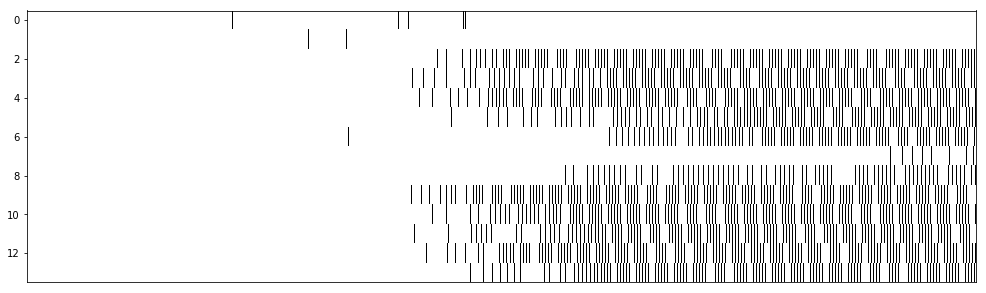

In [4]:
T = 300
dt = 0.05

np.random.seed(10)
net = Network(p=[0.20, 0.80],
              num_synapses=14, 
              num_input_neurons=2, 
              num_reservoir_neurons=10,
              num_readout_neurons=2,
              sparsity=0.5)

# net.summary()
# plot_tuning_curves(net)
tt, stim = get_stimulus(T)
# plot_stimulus(tt,stim)
V, gAMPA, gNMDA, gGABA, postsyn_act, presyn_act, eligibility = simulate(net, stim, T, dt)
# plot_spikes(net, T, dt, V, neur_ids=[0,1,2,3,4,5,6,7])
# plot_conductances(4, net, T, dt)
plot_raster(V)

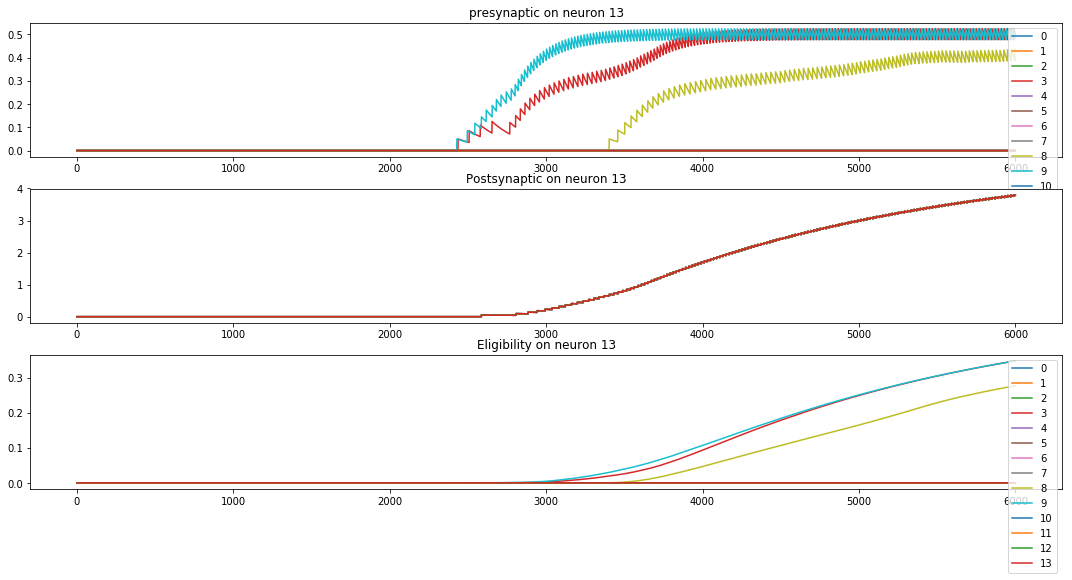

In [5]:
plt.figure(figsize=(15,7))
n = 13
plt.subplot(3, 1, 1)
for s in range(net.M):
    plt.plot(presyn_act[n,s,:])
plt.title('presynaptic on neuron {}'.format(n))
plt.legend(range(net.M))
    
plt.subplot(3, 1, 2)
for s in range(net.M):
    plt.plot(postsyn_act[n,s,:])
plt.tight_layout()
plt.title('Postsynaptic on neuron {}'.format(n))

plt.subplot(3, 1, 3)
for s in range(net.M):
    plt.plot(eligibility[n,s,:])
plt.title('Eligibility on neuron {}'.format(n))
plt.legend(range(net.M))


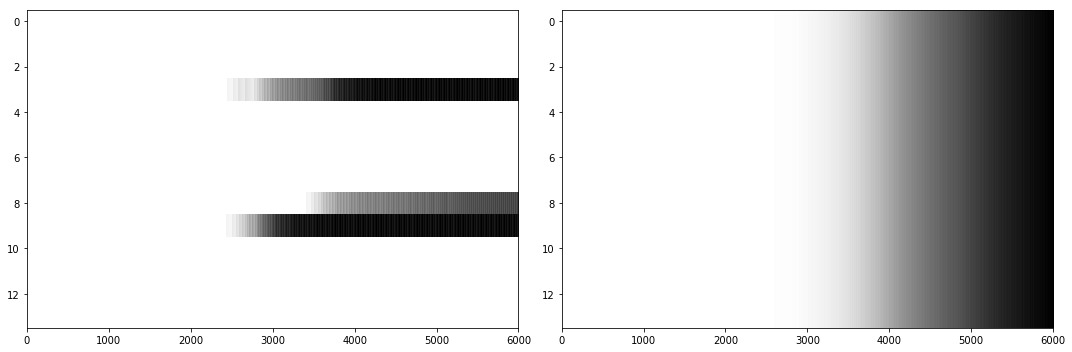

In [6]:
n = 13
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(presyn_act[n,:,:]), interpolation='none', aspect='auto', cmap='Greys')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(postsyn_act[n,:,:]), interpolation='none', aspect='auto', cmap='Greys')
plt.tight_layout()

## Ligher and more efficient implementation:

In [4]:
def plt_elig_wts(e, w):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Eligibility')
    plt.imshow(e)
    plt.ylabel('signaling neurons (synapses \nlistening to respective neurons)')
    plt.xlabel('receiving neurons')
    plt.subplot(1,2,2)
    plt.imshow(w)
    plt.title('Weights')
    plt.ylabel('signaling neurons (synapses \nlistening to respective neurons)')
    plt.xlabel('receiving neurons')

def plot_sim_res(what, net, neur = [0], syn=[]):
    
    N = net.N
    POSTSYN = net.POSTSYN
    PRESYN = net.PRESYN
    ELIGIBILITY = net.ELIGIBILITY
    VV = net.VV
    I_EE = net.I_EE
    I_II = net.I_II
    AMPA = net.AMPA
    NMDA = net.NMDA
    GABA = net.GABA
    mask = net.neur_type_mask
    
    if what=='V':
        leg = []
        plt.figure(figsize=(15,5))
        plt.subplot(2,1,1)
        plt.title('Membrane voltage')
        for n in range(len(neur)):
            plt.plot(net.t, VV[neur[n],:])
            leg.append('{} exc'.format(neur[n]) if net.neur_type_mask[neur[n]]==1 else '{} inh'.format(neur[n]))
        plt.legend(leg, title='Neuron')
        plt.tight_layout()
    elif what=='I':
        plt.figure(figsize=(15,5))
        c = 0
        for n in neur:
            c += 1
            plt.subplot(len(neur),1,c)
            plt.plot(net.t, I_EE[n,:], label='I_E, neur. {}'.format(n))
            plt.plot(net.t, I_II[n,:], linestyle='--', label='I_I, neur. {}'.format(n))
            plt.legend(title='Currents')
        plt.title('I_E and I_I')
        plt.tight_layout()
    elif what=='G':
        plt.figure(figsize=(15, 2*N))
        for n in range(len(neur)):
            plt.subplot(N,1,n+1)
            for s in syn:
                plt.plot(net.t, AMPA[s, neur[n],:], label='AMPA, syn.{}'.format(s))
                plt.plot(net.t, NMDA[s, neur[n],:], linestyle='--', label='NMDA, syn.{}'.format(s))
                plt.plot(net.t, GABA[s, neur[n],:], linestyle=':', label='GABA, syn.{}'.format(s) )
                plt.title('AMPA, NMDA and GABA conductances in receiving neuron: {}'.format(neur[n]))
                plt.legend()
        plt.tight_layout()
    
    elif what=='E':
        plt.figure(figsize=(15,7))
        ax = []
        for i in range(3):
            ax.append(plt.subplot(3,1,i+1))
        for i in neur:
            ax[0].plot(net.t, POSTSYN[i,:], label='Neuron {}'.format(i))
        for i in neur:
            for j in range(N):
                ax[1].plot(net.t, PRESYN[j,i,:], label='Neuron {}, Syn. {}'.format(i,j))
                ax[2].plot(net.t, ELIGIBILITY[j,i,:], label='Neuron {}, Syn. {}'.format(i,j))
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        ax[1].set_title('Presynaptic activity')
        ax[0].set_title('Postsynaptic activity')
        ax[2].set_title('Eligibility')
        plt.tight_layout()
    else:
        pass

In [74]:
class Net2():
    def __init__(self, N=4, T=100, dt=0.01, seed=10):

        np.random.seed(seed)
        self.N = N
        self.T = T
        self.dt = dt
        self.eligibility_lr = 0.1
        self.refractory_period = 1
        self.AP = np.zeros((self.N, 1))

        self.syn_timer = -np.ones((self.N, self.N))
        self.AP_delayed = np.zeros((self.N, self.N))

        # equilibrium potentials:
        self.V_E = 0
        self.V_I = -80  # equilibrium potential for the inhibitory synapse
        self.EL = -65  # leakage potential, mV

        # critical voltages:
        self.Vth = -55  # threshold after which an AP is fired,   mV
        self.Vr = -70  # reset voltage (after an AP is fired), mV
        self.Vspike = 10

        # define neuron types in the network:
        self.neur_type_mask = np.random.choice([0, 1], self.N, p=[0.5, 0.5]).reshape(*self.AP.shape).astype('float64')
        self.neur_type_mask[0] = 1
        self.neur_type_mask[1] = 1
        self.neur_type_mask[-1] = 1
        self.neur_type_mask[-2] = 1
        print('NEUR_TYPE_MASK: {}'.format(self.neur_type_mask))

        # taus
        self.tau = np.zeros((1, self.N))
        self.tau[0, np.where(self.neur_type_mask == 0)[0]] = 10
        self.tau[0, np.where(self.neur_type_mask == 1)[0]] = 20

        self.tau_ampa = 8
        self.tau_nmda = 100
        self.tau_gaba = 8
        self.postsyn_tau = 0.1
        self.presyn_tau = 5
        self.tau_eligibility = 40

        self.V = np.ones((1, self.N)) * self.EL
        self.init_4_1_trial()

        # define weights:
        self.w = np.ones((self.N, self.N)).astype('float') * 0.8
        self.w = self.w + np.random.rand(*self.w.shape) * 0.4

        for i in range(self.N):
            self.w[i, i] = 0
        self.w[:, :2] = 0  # input neurons don't receive synapses
        self.w[:2, -2:] = 0  # output neurons don't listen to input neurons
        self.w[-2:, -2:] = 0  # output neurons don't listen to themselves
        self.w[-2:,:] = 0 # output neurons don't feed back to reservoir
        #         self.w[-2, -1] = 1
        #         self.w[-1, -2] = 1

        self.w_mask = np.ones_like(self.w)
        self.w_mask[:,:2] = 0
        self.w_mask[-2:,:] = 0
        self.w_mask[:,:-2] = 0
#         self.w_mask[2,2] = 0
#         self.w_mask[3,3] = 0
        self.w_mask[:2,-2:] = 0
#         self.w_mask = np.zeros_like(self.w)  # fix all weights except readout connections
#         self.w_mask[2:-2, -2:] = 1
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(self.w)
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(self.w_mask)
        plt.colorbar()
        #         self.w += self.w_mask * np.random.randn(*self.w.shape) * 0.01


        self.i = 0

    def init_4_1_trial(self, stim_type=0):
        self.i = 0
        self.t = np.arange(0, self.T, self.dt)
        self.V = self.V * 0 + self.EL
        self.AP = self.AP * 0
        self.ampa = np.zeros((self.N, self.N))
        self.nmda = np.zeros((self.N, self.N))
        self.gaba = np.zeros((self.N, self.N))
        self.eligibility = np.zeros((self.N, self.N))
        self.postsyn_act = np.zeros((1, self.N))
        self.presyn_act = np.zeros((self.N, self.N))
        self.in_refractory = np.zeros_like(self.postsyn_act)
        self.VV = np.zeros((self.N, len(self.t)))
        self.I_EE = np.zeros((self.N, len(self.t)))
        self.I_II = np.zeros((self.N, len(self.t)))
        self.AMPA = np.zeros((self.N, self.N, len(self.t)))
        self.NMDA = np.zeros((self.N, self.N, len(self.t)))
        self.GABA = np.zeros((self.N, self.N, len(self.t)))
        self.POSTSYN = np.zeros((self.N, len(self.t)))
        self.PRESYN = np.zeros((self.N, self.N, len(self.t)))
        self.ELIGIBILITY = np.zeros((self.N, self.N, len(self.t)))
        self.Ie = np.zeros((self.N, len(t)))
        stim_t = range(int(15 / dt), int(40 / dt))
        if stim_type == 0:
            self.Ie[0, stim_t] = 12
            self.Ie[1, stim_t] = 0
        if stim_type == 1:
            self.Ie[0, stim_t] = 0
            self.Ie[1, stim_t] = 12

    def step(self, stimulus=0):

        preAP = self.AP.dot(np.logical_not(self.AP.T).astype(int))  # turn postsynaptic APs to presynaptic
        inc, out = np.where(preAP == 1)
        self.syn_timer[inc, out] = np.round(1 + np.random.rand() * 2, 2)  # randomized synaptic delay timer
        inc, out = np.where(np.round(self.syn_timer, 4) == 0)
        self.AP_delayed[inc, out] = 1

        self.ampa += (-self.ampa / self.tau_ampa + self.neur_type_mask * self.AP_delayed * self.w) * self.dt
        self.nmda += (-self.nmda / self.tau_nmda + self.neur_type_mask * self.AP_delayed * self.w) * self.dt
        self.gaba += (-self.gaba / self.tau_gaba + (1.0 - self.neur_type_mask) * self.AP_delayed * self.w) * self.dt
        self.postsyn_act += (-self.postsyn_act / self.postsyn_tau + self.AP.T) * self.dt
        self.presyn_act += (-self.presyn_act / self.presyn_tau + self.AP_delayed) * self.dt
        self.eligibility += (self.eligibility_lr * (
            self.presyn_act * self.postsyn_act - self.eligibility / self.tau_eligibility)) * self.dt

        self.AP = self.AP * 0
        self.AP_delayed = self.AP_delayed * 0
        where_reset = np.where(self.V.flatten() >= self.Vspike)[0]
        self.V[:, where_reset] = self.Vr
        self.in_refractory[:, where_reset] = self.refractory_period
        where_refractory = np.where(self.in_refractory.flatten() > 0)[0]

        self.I_E = np.sum(-self.ampa * (self.V - self.V_E) - 0.1 * self.nmda * (self.V - self.V_E), 0)
        self.I_I = np.sum(-self.gaba * (self.V - self.V_I), 0)

        dV = (-(self.V - self.EL) / self.tau + self.I_E + self.I_I + self.Ie[:, self.i]) * self.dt
        dV[0, where_refractory] = 0
        self.V += dV

        where_is_AP = np.where(self.V.flatten() > self.Vth)[0]

        self.V[:, where_is_AP] = self.Vspike
        self.AP[where_is_AP, :] = 1

        self.I_EE[:, self.i] = self.I_E
        self.I_II[:, self.i] = self.I_I
        self.VV[:, self.i] = self.V
        self.AMPA[:, :, self.i] = self.ampa
        self.NMDA[:, :, self.i] = self.nmda
        self.GABA[:, :, self.i] = self.gaba
        self.POSTSYN[:, self.i] = self.postsyn_act.flatten()
        self.PRESYN[:, :, self.i] = self.presyn_act
        self.ELIGIBILITY[:, :, self.i] = self.eligibility
        self.i += 1
        self.in_refractory -= self.dt

        self.syn_timer -= self.dt
        self.AP_delayed *= 0
        
    def softmax(self, x):
        return np.exp(x)/np.sum(np.exp(x), axis=0)

    def learn(self, alpha=None, U=None):

#         dw = self.w_mask * alpha * U * np.tanh(self.eligibility)
        dw = self.w_mask * (alpha * U * self.softmax(self.eligibility) + np.random.rand(*self.w.shape)*0.01)
#         dw = self.w_mask * alpha * U * preprocessing.minmax_scale(self.eligibility, axis=0)
        self.w += dw
        negs0, negs1 = np.where(dw<0)
        Sn = np.sum(dw[negs0, negs1])
        pos0, pos1 = np.where(dw>0)
        Sp = np.sum(dw[pos0, pos1])
        if np.any(self.w < 0):
            sig, rec = np.where(self.w < 0)
            self.w[sig, rec] = 0
            print('Negative weight DETECTED, not corrected {}'.format(np.min(self.w)))
        return Sn, Sp


NEUR_TYPE_MASK: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


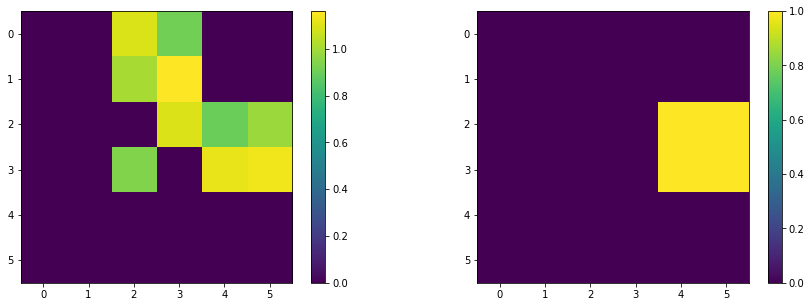

In [75]:
N = 6
T = 100
dt = 0.01
t = np.arange(0, T, dt)
net = Net2(N=N, T=T, dt=dt, seed=222)
W_init = np.copy(net.w)

In [78]:
rr = 0
ACC = []
for trial in range(50):
    stim = np.random.choice(2)
    time = TIME.time()
    net.init_4_1_trial(stim_type=stim)
    for i in range(len(t)):
        net.step()
        
    if np.any(net.postsyn_act[:,-2:] == 0):
        reward = -0.25
        if np.abs(net.postsyn_act[:,-1] - net.postsyn_act[:,-2]) == 0:
            reward = np.random.choice([-0.5, 0.5])
    elif np.argmax(net.postsyn_act[:,-2:]) == stim:
        reward = 1
    else:
        reward = -1   
    rr += 1 if reward==1 else 0
    acc = rr/(trial+1)
    p = 1-binom.cdf(rr, trial+1, 0.5)
    ACC.append(acc)
    
    Sn, Sp = net.learn(alpha=0.05, U=reward)
    print('Trial {:.0f}, sim.t: {:.1f}\t Reward: {:.2f}\t Sw: {:.5f}\t Sw_u-: {:.5f} Sw_u+: {:.5f}\t acc: {:.2f}\t p = {:.2f}'.format(trial,
                                                                            TIME.time() - time,
                                                                            reward,
                                                                            net.w.sum(),
                                                                            Sn, Sp,                                                                                                                      
                                                                            acc,
                                                                            p))

Trial 0, sim.t: 2.3	 Reward: 1.00	 Sw: 10.50425	 Sw_u-: 0.00000 Sw_u+: 0.04509	 acc: 1.00	 p = 0.00
Trial 1, sim.t: 2.5	 Reward: -1.00	 Sw: 10.48801	 Sw_u-: -0.01624 Sw_u+: 0.00000	 acc: 0.50	 p = 0.25
Trial 2, sim.t: 2.2	 Reward: -0.50	 Sw: 10.50677	 Sw_u-: 0.00000 Sw_u+: 0.01875	 acc: 0.33	 p = 0.50
Trial 3, sim.t: 2.2	 Reward: -1.00	 Sw: 10.50130	 Sw_u-: -0.00617 Sw_u+: 0.00071	 acc: 0.25	 p = 0.69
Trial 4, sim.t: 2.2	 Reward: -1.00	 Sw: 10.47296	 Sw_u-: -0.02834 Sw_u+: 0.00000	 acc: 0.20	 p = 0.81
Trial 5, sim.t: 2.2	 Reward: 1.00	 Sw: 10.51828	 Sw_u-: 0.00000 Sw_u+: 0.04532	 acc: 0.33	 p = 0.66
Trial 6, sim.t: 2.2	 Reward: 1.00	 Sw: 10.57636	 Sw_u-: 0.00000 Sw_u+: 0.05808	 acc: 0.43	 p = 0.50
Trial 7, sim.t: 2.2	 Reward: 1.00	 Sw: 10.63111	 Sw_u-: 0.00000 Sw_u+: 0.05475	 acc: 0.50	 p = 0.36
Trial 8, sim.t: 2.2	 Reward: -1.00	 Sw: 10.60675	 Sw_u-: -0.02436 Sw_u+: 0.00000	 acc: 0.44	 p = 0.50
Trial 9, sim.t: 2.2	 Reward: -1.00	 Sw: 10.59583	 Sw_u-: -0.01097 Sw_u+: 0.00005	 acc: 0.40

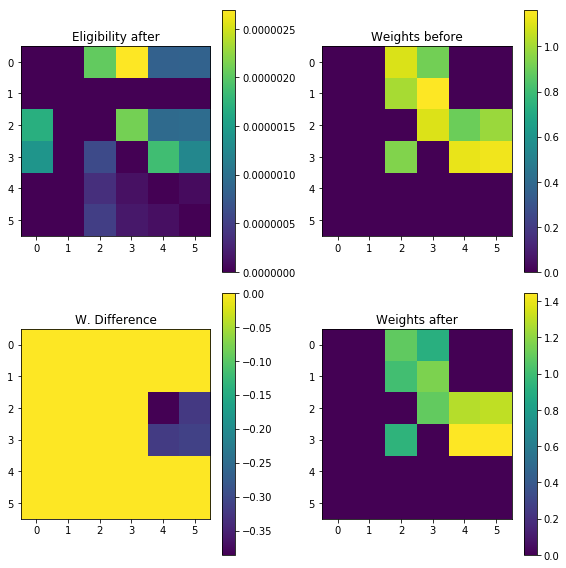

In [80]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(net.eligibility)
plt.title('Eligibility after')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(W_init)
plt.colorbar()
plt.title('Weights before')
plt.subplot(2,2,4)
plt.imshow(net.w)
plt.colorbar()
plt.title('Weights after')
plt.subplot(2,2,3)
plt.imshow(W_init - net.w)
plt.title('W. Difference')
plt.colorbar()
plt.tight_layout()

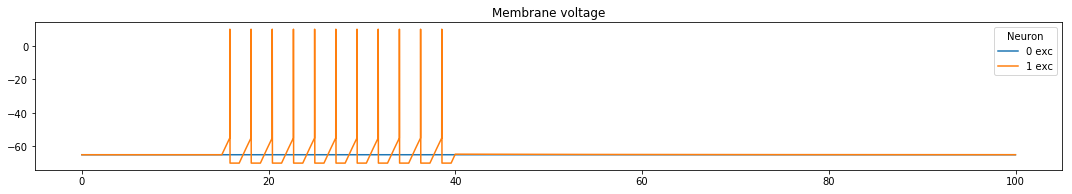

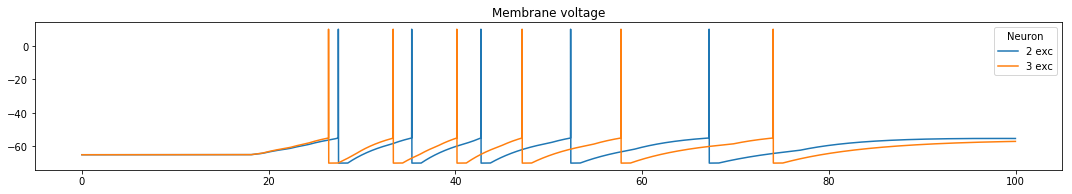

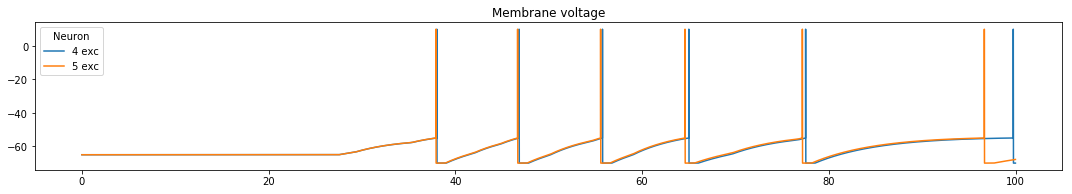

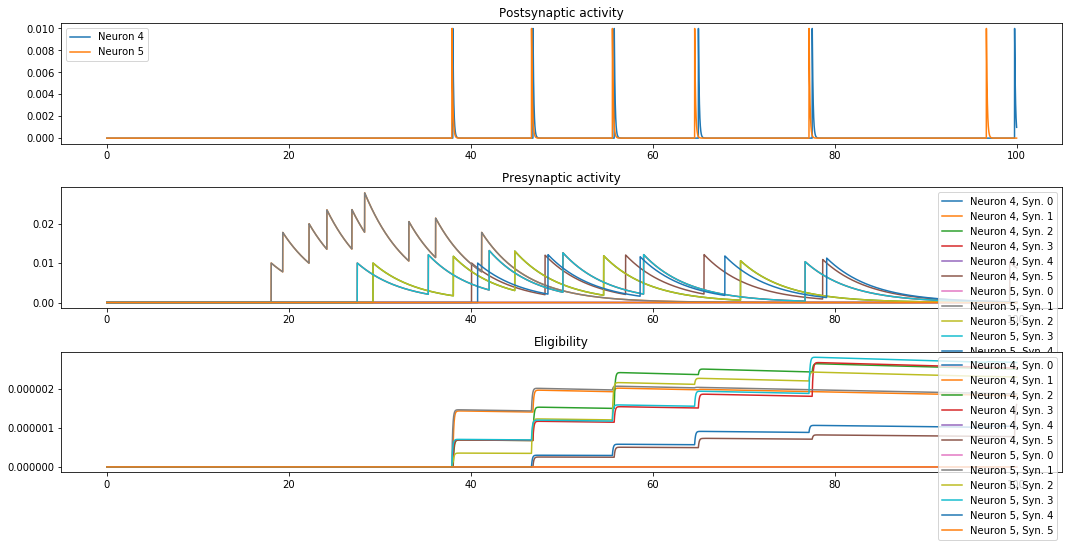

In [81]:
stim = 1
net.init_4_1_trial(stim_type=stim)
for i in range(len(t)):
    net.step()
plot_sim_res('V', net, neur=[0,1])
plot_sim_res('V', net, neur=[2,3])
plot_sim_res('V', net, neur=[4,5])
# plot_sim_res('G', net, neur=[2,3], syn=[0,1])
plot_sim_res('E', net, neur=[4,5])

# stim = 1
# net.init_4_1_trial(stim_type=stim)
# for i in range(len(t)):
#     net.step()
# # plot_sim_res('V', net, neur=[0,1])
# plot_sim_res('V', net, neur=[2,3])
# plot_sim_res('E', net, neur=[2,3])

In [ ]:
plot_sim_res('V', net, neur=[0,1])
plot_sim_res('G', net, neur=[2,3], syn=[0,1])

In [ ]:
plot_sim_res('I', net, neur=[2, 3, 4, 5])

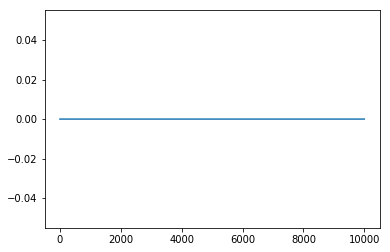

In [151]:
# plt.plot(net.VV[0,:])
plt.plot(net.GABA[4,5,:]*10000000)

In [9]:
a = np.random.randint(20, size=(1, 10))
a

array([[14, 13, 13,  2,  3, 13,  4, 16, 11, 14]])

In [26]:
a_ = preprocessing.minmax_scale(a.flatten())


/Users/RomanKoshkin/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


/Users/RomanKoshkin/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


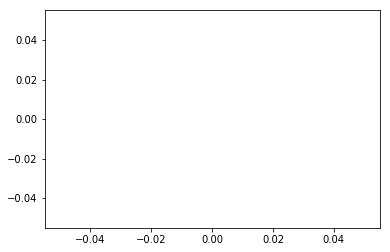

In [19]:
from sklearn import preprocessing
y_ = np.tanh(a_)
plt.plot(a_,y_)




In [34]:
a = np.random.randint(10, size=(4,5))
a

array([[3, 9, 1, 2, 4],
       [3, 9, 8, 4, 4],
       [9, 8, 4, 7, 6],
       [5, 8, 3, 2, 4]])

In [47]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=0)

# print(preprocessing.minmax_scale(a))
print(np.round(softmax(a), 2))

[[0.   0.37 0.   0.01 0.1 ]
 [0.   0.37 0.97 0.05 0.1 ]
 [0.98 0.13 0.02 0.94 0.71]
 [0.02 0.13 0.01 0.01 0.1 ]]
